## Meta Analysis

### 1. Create Dataset
If you already have a dataset, you do not have to follow this section, we are going to show how the simulation will be done.

In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname(os.path.abspath(os.path.dirname('pwd'))))))

In [240]:

import pandas as pd
import numpy as np
def seed_everything(seed):
    np.random.seed(seed)
    # torch.manual_seed(seed)
    # torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # torch.backends.cudnn.deterministic = True
    # torch.backends.cudnn.benchmark = False
    # torch.backends.cudnn.enabled = False
    # torch.use_deterministic_algorithms(True)



seed=1337
seed_everything(seed)

In [241]:
import argparse
parser = argparse.ArgumentParser(description='Args Sparse Simulation')
parser.add_argument('--p_num', type=int, default=10, help='num ber of permutation')
parser.add_argument('--x_grid_start',type=int, default=1,help='start of the x-axis')
parser.add_argument('--x_grid_end',type=int, default=20,help='end of the x-axis')
parser.add_argument('--same_ratio',type=int, default=90,help='Difference ratio for each group') ## only can choose 50,90, 100
parser.add_argument('--interval',type=float,default=0.1,help='interval for x-axis' )
parser.add_argument('--epsilon',type=float,default=0.0001,help='to_avoid zero division')
args, _ = parser.parse_known_args()

# please decrease the ratio of the first half by 0.5 and increase the ratio for decreased amount to the second half
beta=0.7
# randomly select the number of microiomes to change the ratio
num_microbiomes_to_change=200
# sort
sort_option=False



otu=pd.read_csv("throatotu_csv.csv")

otu['x']
# drop three most abundant species

#sort 
otu=otu.sort_values(by='x',ascending=False)
otu=otu.iloc[3:]



# divide by sum of the row
ratio=otu['x']/otu['x'].sum()


# randomly select the microbiomes to change the ratio
ratio=ratio.to_numpy()
if sort_option ==False:
    # sort ratio
    np.random.shuffle(ratio)




ratio_to_change=ratio[:num_microbiomes_to_change]
ratio_to_change
ratio_fixed=ratio[num_microbiomes_to_change:]

decreased=ratio_to_change[:int(len(ratio_to_change)/2)]-ratio_to_change[:int(len(ratio_to_change)/2)]*beta

ratio_change_first_half=ratio[:int(len(ratio_to_change)/2)]-decreased
ratio_second_half=ratio_to_change[int(len(ratio_to_change)/2):]
increased=np.zeros(len(ratio_second_half))
sum_ratio_second_half=ratio_second_half.sum()   

for i in range(len(ratio_second_half)):

    increased[i]=(decreased.sum()*ratio_second_half[i])/sum_ratio_second_half
# distribute the increased ratio to the second half with equivalent to 

ratio_second_half=ratio_to_change[int(len(ratio_to_change)/2):]+increased

g1_param=ratio
g_changed=np.concatenate([ratio_change_first_half,ratio_second_half])
g2_param=np.concatenate([g_changed,ratio_fixed])


Now, the parameters for generating samples for each group have been made. 
for g1, and g2 , Now using dirichlet distribution, we try to generate samples. 
We have to choose overdispersion parameter $\theta$ 


In [271]:
theta=0.000001 # overdispersion parameter
num_samples=50 # number of samples.  this will be a major paramter. 

g1=np.random.dirichlet(g1_param*(1/theta),size=num_samples)
g2=np.random.dirichlet(g2_param*(1/theta), size=num_samples)
# s

#what i watn to do is get dividing rowwise summation
# g1_normalized = g1_count / g1_count.sum(axis=1)[:, np.newaxis]
# g2_normalized = g2_count / g2_count.sum(axis=1)[:, np.newaxis]

In [272]:
g1.shape

(50, 853)

In [278]:
#take log and minus
g1_entropy = np.where(g1 > 0, -np.log(g1), 0)
g2_entropy = np.where(g2 > 0, -np.log(g2), 0)
g1_entropy=g1_entropy.T
g2_entropy=g2_entropy.T

### 2. Finding bandwidth for each feature
then, you select one group to find some relationship between standard deviation that data itself have. 
by calling the function ```finddistribution```, you can obtain the bandwidth for each feature. 

In [3]:
from src.Grouping import Groupinfo
x_grid=np.arange(0,15,0.1)
feat_info=np.zeros(g1_entropy.shape[0])
feat_info+=1 ## as this is simulated  case, you cannot consider the prior-posterior case. 
t1=Groupinfo(g1_entropy)
t1.finddistribution(x_grid,epsilon=0.0001,feat_info=feat_info)

then by using the defined functions, you can get the sigma and bandwidth for the generated case. 

In [4]:
bw=np.array(t1.group_bandwidth)
sig=np.sqrt(np.array(t1.getsigma()))
from matplotlib import pyplot as plt

In [5]:
bw

array([0.1 , 0.3 , 0.4 , 0.35, 0.15, 0.25, 0.2 , 0.45, 0.15, 0.25, 0.3 ,
       0.35, 0.15, 0.35, 0.15, 0.2 , 0.4 , 0.25, 0.35, 0.25, 0.4 , 0.15,
       0.4 , 0.35, 0.2 , 0.4 , 0.15, 0.15, 0.2 , 0.45, 0.15, 0.45, 0.3 ,
       0.3 , 0.25, 0.2 , 0.45, 0.3 , 0.4 , 0.35, 0.4 , 0.35, 0.3 , 0.25,
       0.3 , 0.25, 0.3 , 0.45, 0.4 , 0.45, 0.15, 0.4 , 0.4 , 0.35, 0.35,
       0.45, 0.1 , 0.25, 0.4 , 0.15, 0.15, 0.4 , 0.25, 0.4 , 0.1 , 0.35,
       0.3 , 0.4 , 0.4 , 0.4 , 0.4 , 0.4 , 0.35, 0.2 , 0.35, 0.2 , 0.4 ,
       0.3 , 0.35, 0.25, 0.35, 0.1 , 0.35, 0.25, 0.15, 0.3 , 0.3 , 0.4 ,
       0.4 , 0.4 , 0.2 , 0.4 , 0.3 , 0.4 , 0.3 , 0.15, 0.4 , 0.3 , 0.45,
       0.3 , 0.45, 0.25, 0.2 , 0.1 , 0.1 , 0.25, 0.35, 0.15, 0.15, 0.3 ,
       0.4 , 0.15, 0.35, 0.4 , 0.25, 0.15, 0.4 , 0.4 , 0.2 , 0.4 , 0.45,
       0.1 , 0.4 , 0.25, 0.15, 0.35, 0.35, 0.35, 0.4 , 0.4 , 0.1 , 0.4 ,
       0.1 , 0.45, 0.3 , 0.45, 0.35, 0.15, 0.4 , 0.35, 0.1 , 0.3 , 0.25,
       0.1 , 0.15, 0.35, 0.25, 0.35, 0.3 , 0.45, 0.

this is a scatter of randomly generated data

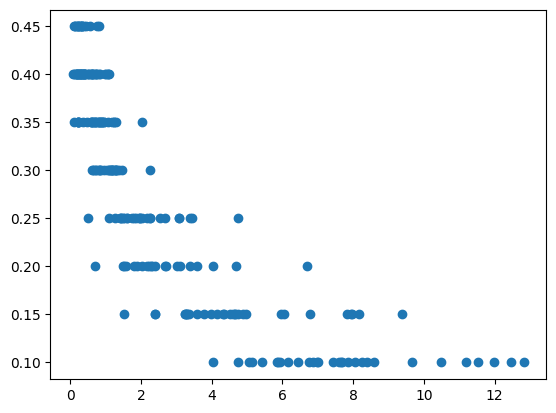

In [6]:
plt.scatter(sig,bw)

now based on the plot's structure you can eiter fit log or polynomial regression to the data. 

In [18]:
model = np.poly1d(np.polyfit(sig, bw, 2))
coef=model.coefficients
x_grid=np.arange(0,13,0.1)

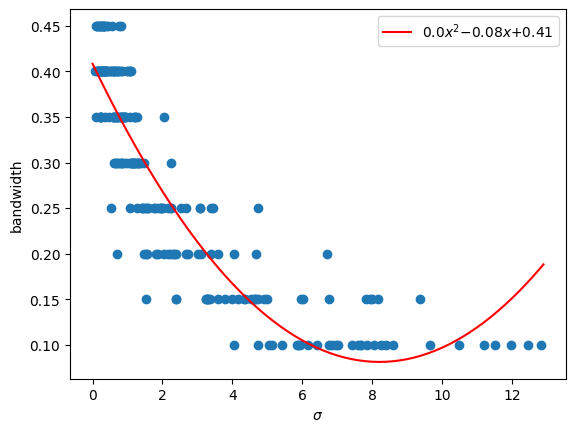

In [19]:
plt.scatter(sig,bw)
plt.xlabel('$\sigma$')
plt.ylabel('bandwidth')
plt.plot(x_grid,((x_grid**2)*coef[0]+(x_grid)*coef[1]+coef[2]),color='r',label='${}x^2$${}x$+{}'.format(round(coef[0],2),round(coef[1],2),round(coef[2],2)))
plt.legend()